In [140]:
import copy
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy

from matplotlib.lines import Line2D

from yass.evaluate.stability import *
from yass.evaluate.util import *
from yass.geometry import parse, find_channel_neighbors

from deconv_exp_utils import *

from tqdm import tqdm
#import mpld3

from deconv_exp_utils import vis_chan, recon

%matplotlib inline

In [2]:
base_dir = '/ssd/data/peter/ej49_dataset'

raw = os.path.join(base_dir, 'ej49_data1_set1.bin')
geom = os.path.join(base_dir, 'ej49_geometry1.txt')
st_file = os.path.join(base_dir, 'groundtruth_ej49_data1_set1.mat')

rbi = RecordingBatchIterator(
    rec_file=raw, n_chan=49, batch_time_samples=1000000,
    geom_file=geom, n_batches=6, radius=70, sample_rate=20000,
    whiten=False)

In [3]:
gold_sp = sio.loadmat(st_file)
gold_sp = np.append(gold_sp['spt_gt'], gold_sp['L_gt'])
gold_sp = gold_sp.reshape([2, len(gold_sp) // 2]).T

gold_sp

array([[      7,      40],
       [     13,      27],
       [     51,      29],
       ...,
       [5999929,      46],
       [5999931,      34],
       [5999991,       8]], dtype=int32)

In [4]:
mwc = MeanWaveCalculator(batch_reader=rbi, spike_train=gold_sp, window=range(-20, 30))
mwc.compute_templates(6)

100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


8

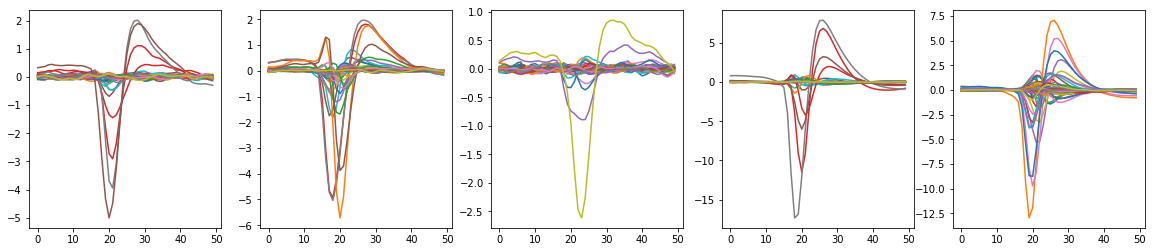

In [6]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].plot(mwc.templates[:, :, i])
fig.set_size_inches(20, 4)

# Fake spike train

''

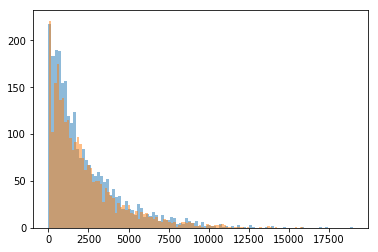

In [5]:
unit = 10
unit_sp = gold_sp[gold_sp[:, 1]==unit, 0]
a = np.random.exponential(np.mean(np.diff(unit_sp)), len(unit_sp))
plt.hist(a, 100, alpha=0.5)
plt.hist(np.diff(unit_sp), 100, alpha=0.5)
''

# Align templates

In [ ]:
# align templates or not
t_l = []
for unit in tqdm(range(n_unit)):
    t, _ = optimal_aligned_compress(mwc.templates[:, :, unit])
    t_l.append(t.T)
t_l = np.array(t_l).T
t_l = scipy.signal.resample(t_l, int(t_l.shape[0] / 5.))
#

# Make fake data

In [212]:
T = int(1e5)
RANK = 3
ALIGN = False

NOISE = False

TEMP = mwc.templates
if ALIGN:
    TEMP = t_l

sp_len = TEMP.shape[0]
n_ch = TEMP.shape[1]
n_unit = TEMP.shape[2]
gold_sp_trunc = gold_sp[gold_sp[:, 0] < T - sp_len, :]

data = np.zeros([T, n_ch])
if NOISE:
    data = np.random.normal(0, 1, [T, n_ch])

for unit in range(n_unit):
    unit_sp = gold_sp_trunc[gold_sp_trunc[:, 1] == unit, 0]
    unit_temp = TEMP[:, :, unit]
    for sp in unit_sp:
        data[sp:sp + sp_len] += unit_temp

rec_temps = copy.copy(TEMP)
for unit in range(n_unit):
    rec_temps[:, :, unit] = recon(TEMP[:, :, unit], rank=RANK)

for unit in range(n_unit):
    unit_sp = gold_sp_trunc[gold_sp_trunc[:, 1] == unit, 0]
    rec_temp = rec_temps[:, :, unit]
    for sp in unit_sp:
        data[sp:sp + sp_len] -= rec_temp

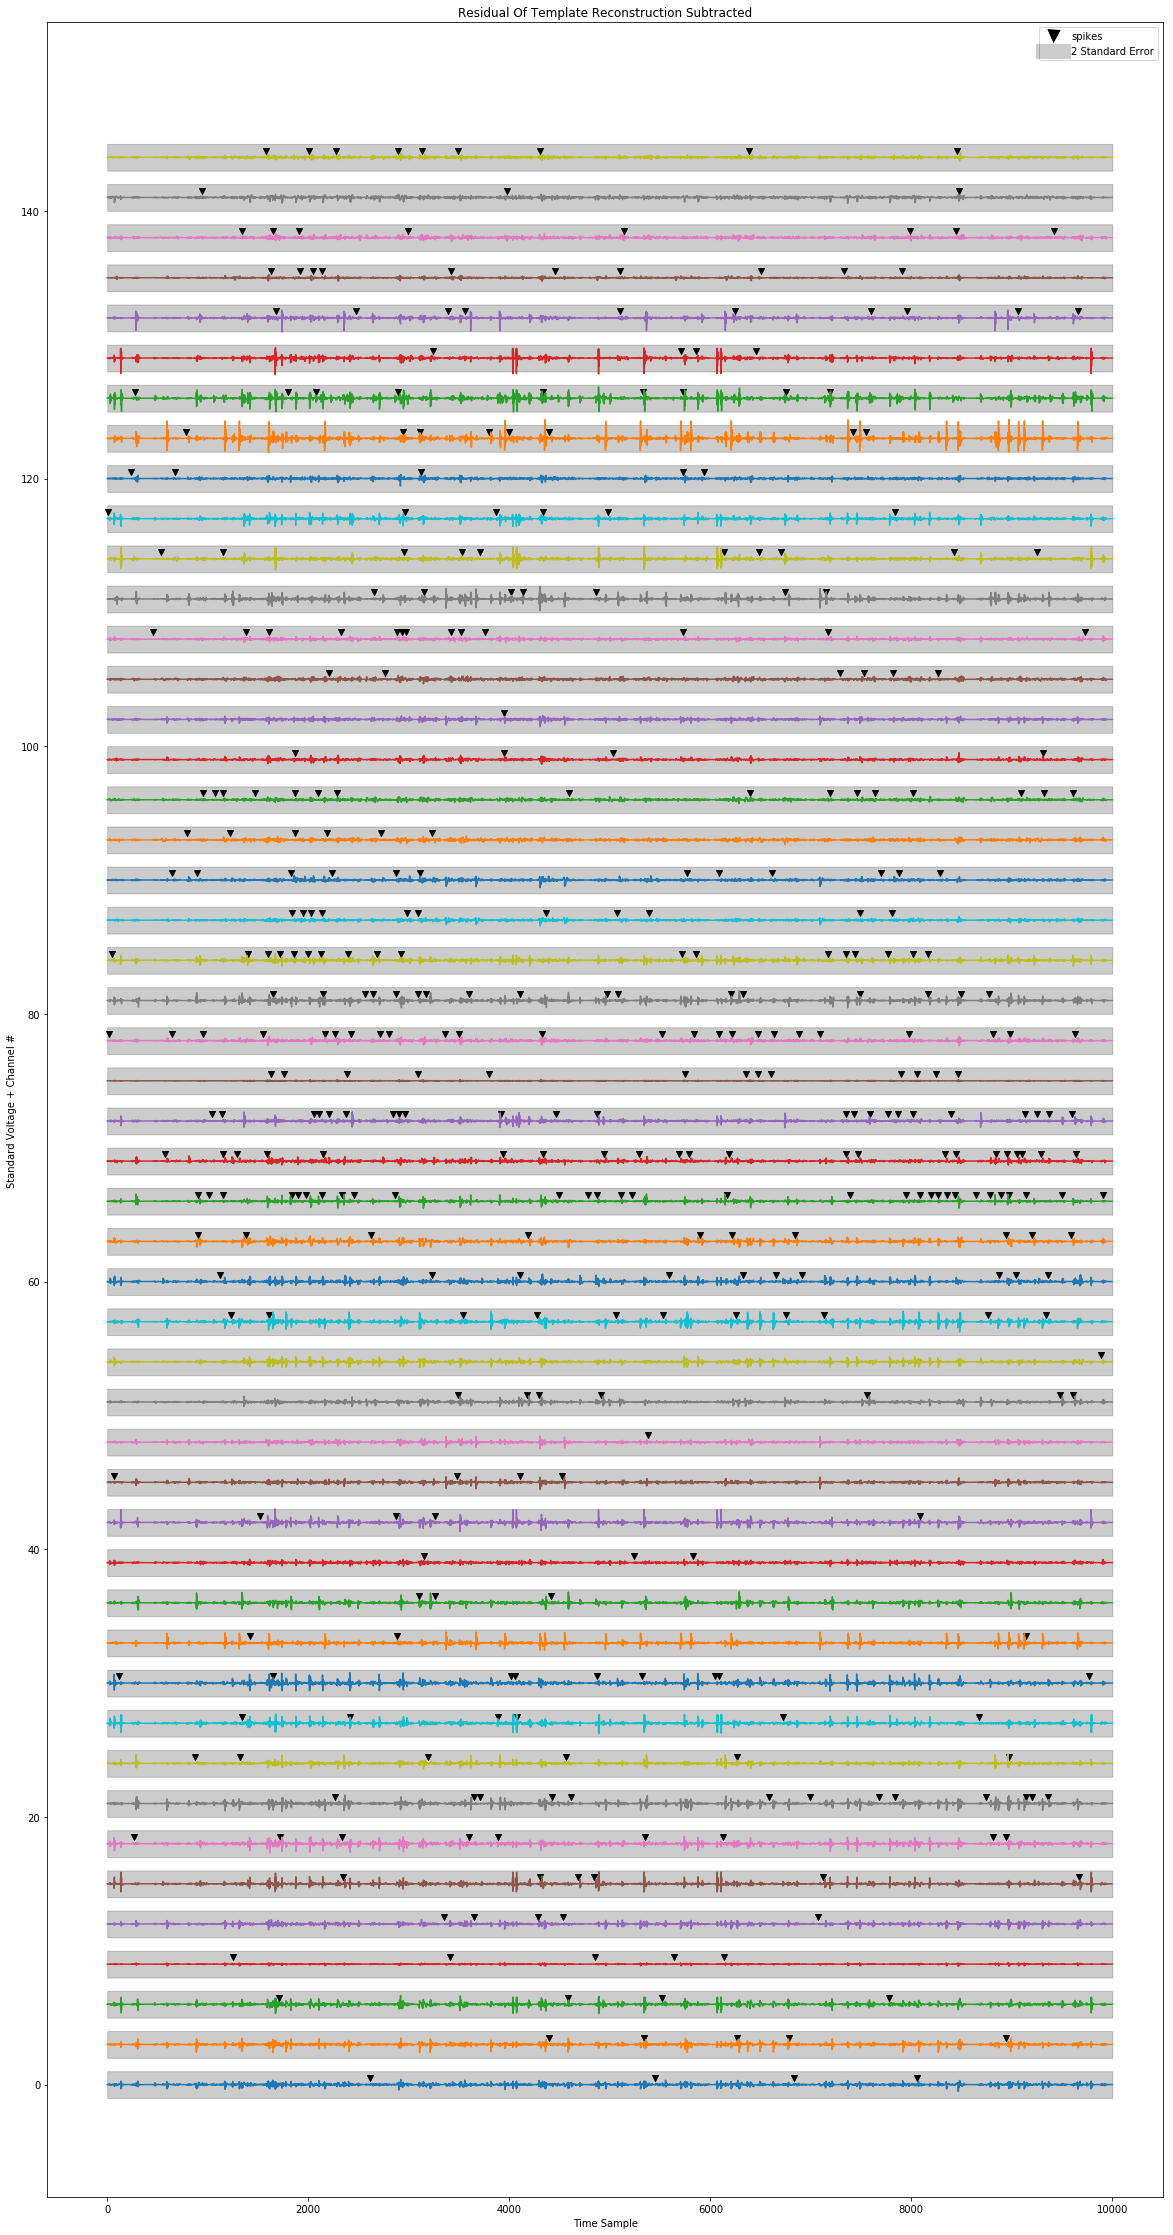

In [213]:
trunc_to = 10000
gold_sp_trunc = gold_sp[gold_sp[:, 0] < trunc_to, :]

fig, ax = plt.subplots()
for c in range(49):
    unit_sp = gold_sp_trunc[gold_sp_trunc[:, 1] == c, 0]
    offset = 3 * c
    ax.scatter(unit_sp, np.zeros(len(unit_sp)) + offset + 0.5, color='0', marker='v')
    ax.plot(data[:trunc_to, c] + offset)
    ax.fill_between(
        range(trunc_to),
        np.zeros(trunc_to) + offset + 1,
        np.zeros(trunc_to) + offset - 1, color='0', alpha=0.2)

legend_elements = [Line2D([0], [0], marker='v', color='w', label='spikes',
                          markerfacecolor='0', markersize=15),
                   Line2D([0], [0], lw=15, color='0', alpha=0.2, label='2 Standard Error')]
ax.legend(handles=legend_elements)

fig.set_size_inches(20, 40)
ax.set_xlabel("Time Sample")
ax.set_ylabel("Standard Voltage + Channel #")
if ALIGN:
    ax.set_title('Residual Of ALIGNED Template Reconstruction Subtracted')
    plt.savefig('data_residual_rank{}_aligned.pdf'.format(RANK))
else:
    ax.set_title('Residual Of Template Reconstruction Subtracted')
    plt.savefig('data_residual_rank{}.pdf'.format(RANK))

In [221]:
scipy.signal.argrelmax(data)

(array([    7,     7,     7, ..., 99992, 99992, 99992]),
 array([ 3, 18, 21, ..., 40, 43, 45]))

In [101]:
#mpld3.enable_notebook()
#mpld3.disable_notebook()

# Convolution and its Approximation using SVD

In [34]:
def conv_filter(temp, approx_rank=None, mode='full'):
    n_chan = temp.shape[1]
    conv_res = 0.
    if approx_rank is None or approx_rank > n_chan:
        for c in range(n_chan):
            conv_res += np.convolve(data[:, c], temp[:, c], mode)
    # Low rank approximation of convolution
    else:
        u, s, vh = np.linalg.svd(temp)
        for i in range(approx_rank):
            conv_res += np.convolve(
                np.matmul(data, vh[i, :].T),
                s[i] * u[:, i].flatten(), mode)
    
    return conv_res

def conv_filter_all(temps, approx_rank=None):
    n_unit = temps.shape[2]
    res_mat = []
    for unit in tqdm(range(n_unit)):
        res_mat.append(conv_filter(temps[:, :, unit], approx_rank=approx_rank))
    return np.array(res_mat)

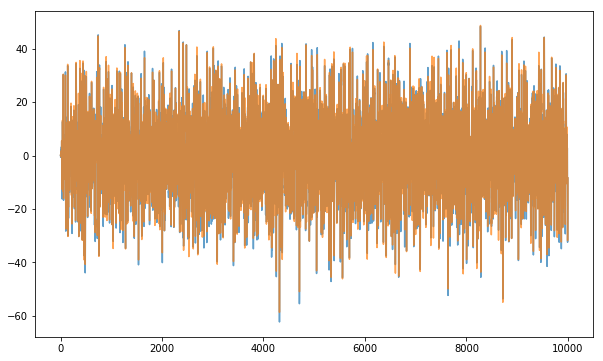

In [35]:
fig, ax = plt.subplots()
ax.plot(conv_filter(mwc.templates[:, :, 0])[:10000], alpha=0.7)
ax.plot(conv_filter(mwc.templates[:, :, 0], approx_rank=3)[:10000], alpha=0.7)
fig.set_size_inches(10, 6)

In [40]:
res = conv_filter_all(mwc.templates)

100%|██████████| 49/49 [00:06<00:00,  7.84it/s]


100%|██████████| 49/49 [00:00<00:00, 571.46it/s]


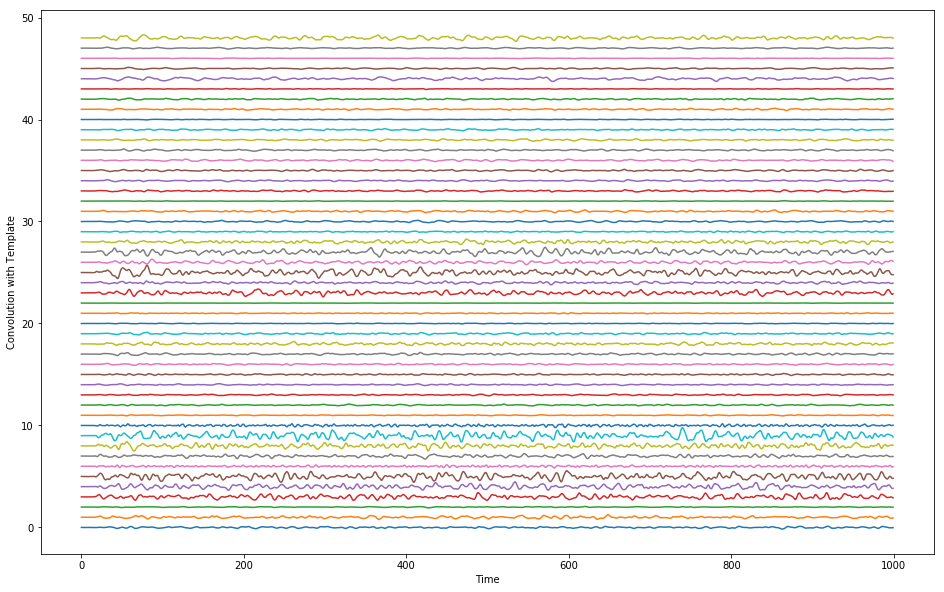

In [45]:
fig, ax = plt.subplots()

trunc_to = 1000
trunc_res = res[:, :trunc_to]

res /= np.max(res)
for unit in tqdm(range(49)):
    ax.plot(trunc_res[unit, :] + unit)

ax.set_xlabel('Time')
ax.set_ylabel('Convolution with Template')
fig.set_size_inches(16, 10)

In [60]:

res = conv_filter_all(mwc.templates)

100%|██████████| 49/49 [00:06<00:00,  7.70it/s]


100%|██████████| 49/49 [00:00<00:00, 265.66it/s]


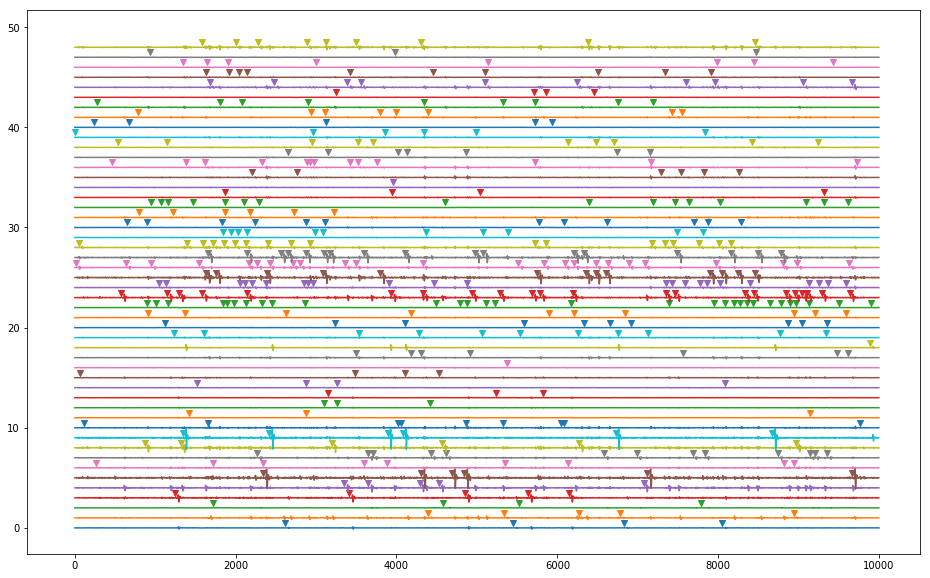

In [62]:
fig, ax = plt.subplots()

trunc_to = 10000
trunc_res = res[:, :trunc_to]
gold_sp_trunc = gold_sp[gold_sp[:, 0] < trunc_to, :]

res /= np.max(res)
for unit in tqdm(range(49)):
    ax.plot(trunc_res[unit, :] + unit)
    unit_sp = gold_sp_trunc[gold_sp_trunc[:, 1] == unit, 0]
    ax.scatter(unit_sp, np.zeros(len(unit_sp)) + unit + 0.5, marker='v')

fig.set_size_inches(16, 10)

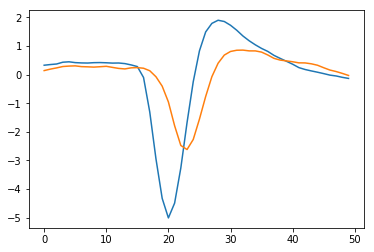

(99,)


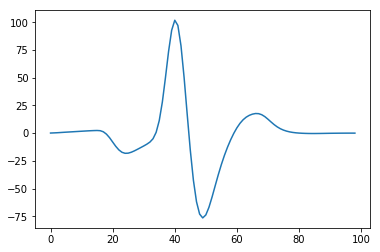

In [204]:
unit1, unit2 = 0, 2
temp1, temp2 = mwc.templates[:, :, unit1], mwc.templates[:, :, unit2]
temp1, temp2 = temp1[:, main_channels(temp1)[-1]], temp2[:, main_channels(temp2)[-1]]

temp_len = len(temp1)

plt.plot(temp1)
plt.plot(temp2)
plt.show()

temp_temp = np.convolve(temp1, temp1, mode='full')
print temp_temp.shape
plt.plot(temp_temp)
plt.show()

251 250
252 250
252 250
250 251
252 250
249 249
253 250
250 251
250 251
254 250


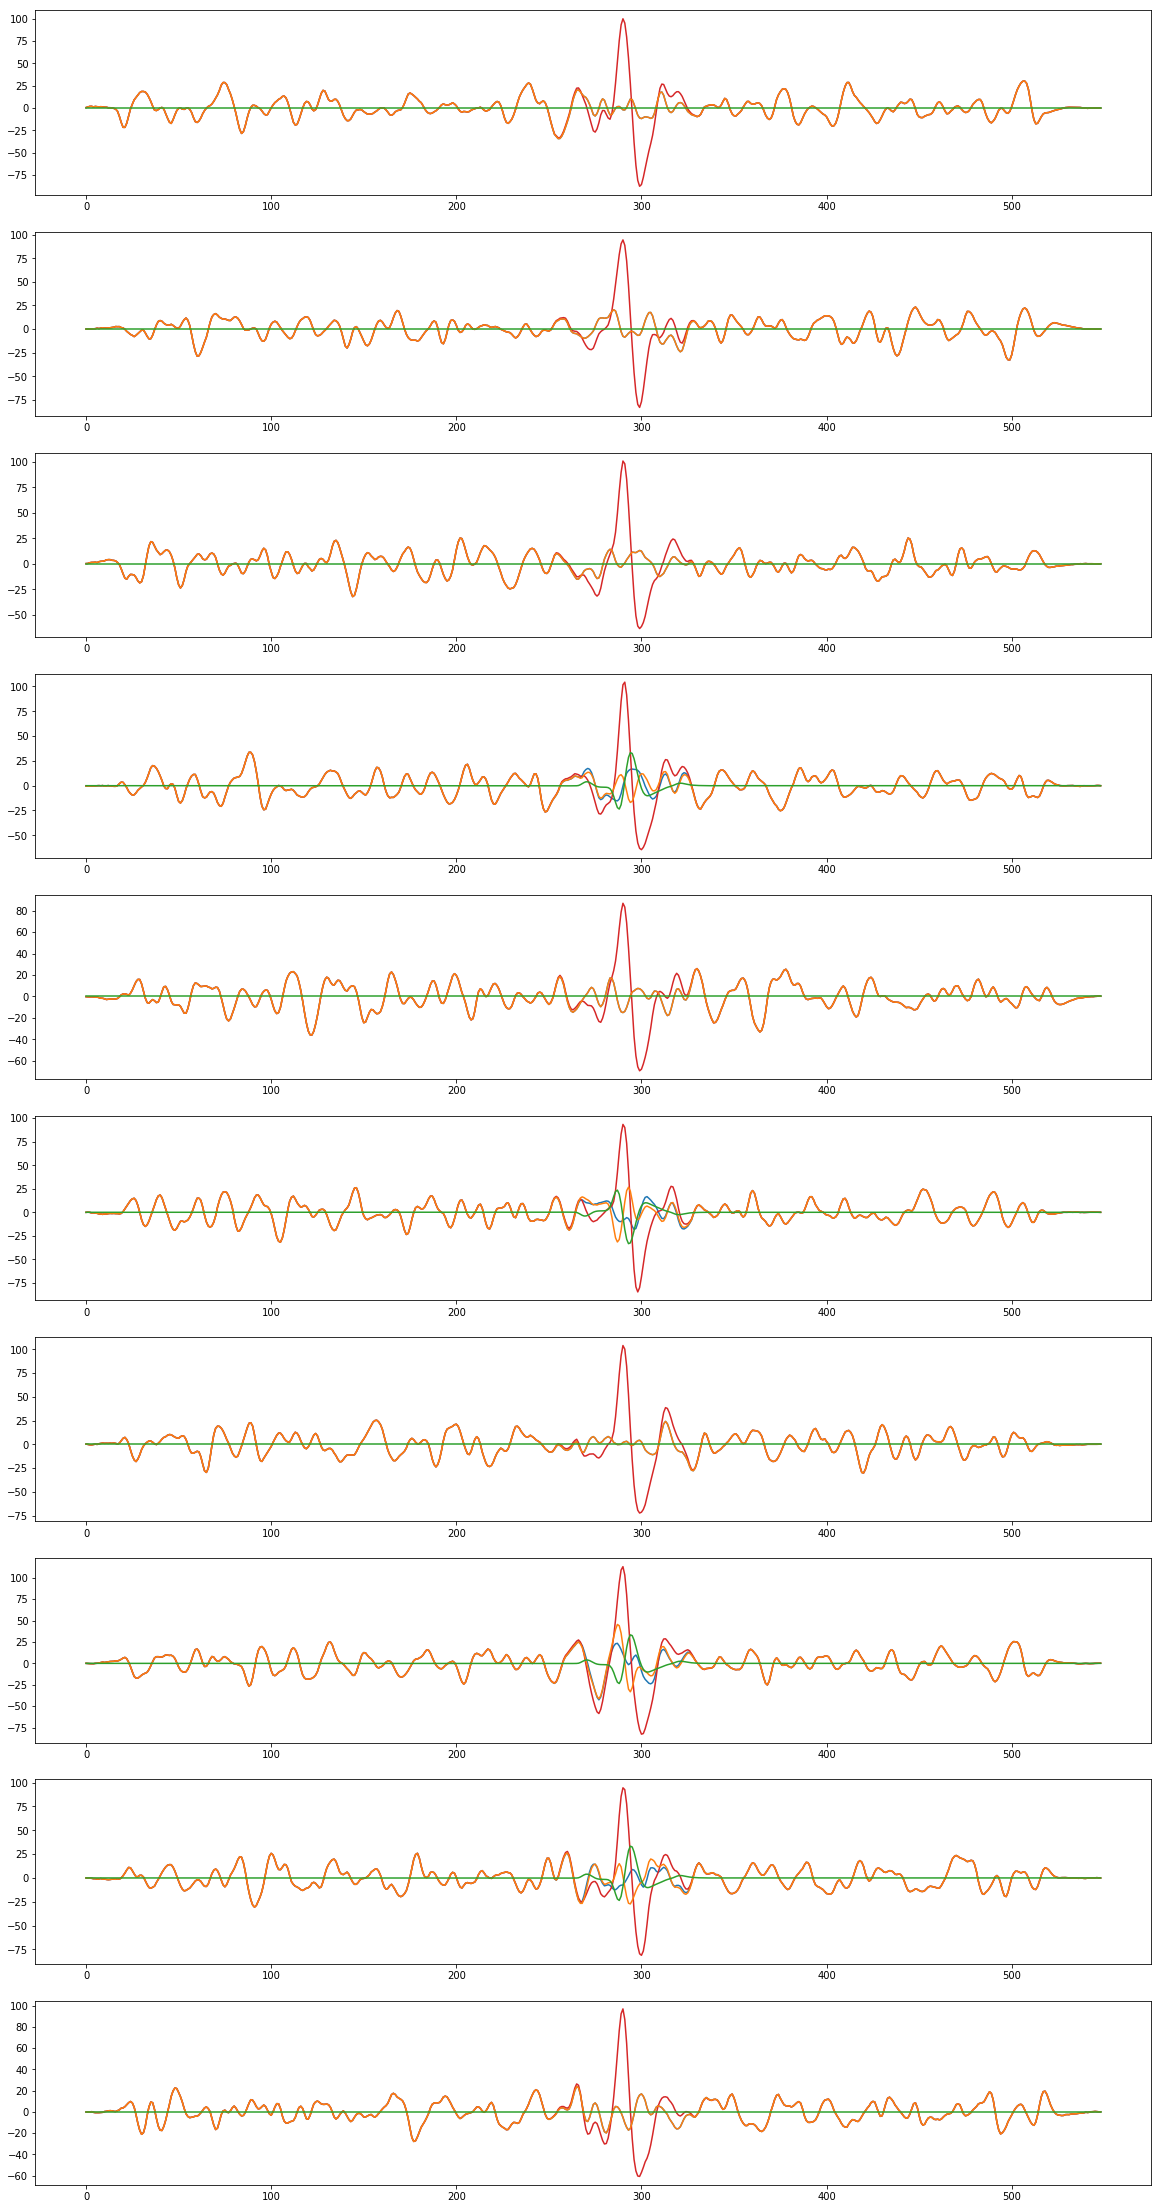

In [211]:
N = 10

fig, ax = plt.subplots(N, 1)

for i in range(N):
    d = np.random.normal(0, 1, 500)
    orig_c = np.convolve(d, temp1, mode='full')
    ax[i].plot(orig_c, 'C0')
    d[250:250+temp_len] += temp1
    #d[750:750+temp_len] += temp2

    new_c = np.convolve(d, temp1, mode='full')
    ax[i].plot(new_c, color='C3')
    where = np.argmin(new_c) - temp_len + 1
    #where = 250

    new_c[where:where+temp_len*2-1] -= temp_temp
    ax[i].plot(new_c, 'C1')
    ax[i].plot(orig_c - new_c , 'C2')

    window = np.where(np.abs(orig_c - new_c)>0)[0]
    print window[0], where

fig.set_size_inches(20, N * 4)

# Optimal Alignment

# SVD Optimal Alignment

# Liam's  SVD Optimal Alignment

# Reconstruction Residuals for Optimal SVD Alignment

# SVD Ranks for Alignment vs. Non-Aligend Templates

# Pulling Waveforms